# Evaluating the performance for each model with the actual dataset from "KMA"

### Librairies

In [1]:
pip install dmba

Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, f1_score, confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pylab as plt
import seaborn as sns

import dmba
from dmba import regressionSummary, classificationSummary, liftChart, gainsChart

%matplotlib inline

## Introduction : some analysis about the dataset

## Information for the evaluation :
Original dataset come from KMA.go.kr, last updated 4th of June.
It has been partitioned in two : 

- 2000-01-01 to 2024-12-31 for the "kma_train.csv", 
- 2025-01-01 to 2025-06-04 for the "kma_test.csv"

To evaluate the model, you should have this code in the same file as "kma_train.csv", "kma_test.csv" and also "result.csv", which gaves the result of the model (rainfall) for test values.

Commentaires : 
- Split the data from train : for cross validation
- Correlation matrix
- ROC curves
- Lift gain
- Lift chart
- r2 score

Load data frame and select columns for regression analysis

In [3]:
df_train = pd.read_csv('kma_train.csv')
df_test = pd.read_csv('kma_test.csv')
outcome = 'rainfall'

y_true = df_test[outcome]
y_true

0      0.0
1      0.0
2      0.0
3      0.0
4      1.0
      ... 
150    0.0
151    0.0
152    0.0
153    0.0
154    0.0
Name: rainfall, Length: 155, dtype: float64

Typical evaluations

In [16]:
predictions = pd.read_csv('prophet_future_df.csv')
predictions

,date,rainfall
0,0,0.158968
1,1,-0.126517
2,2,0.056552
3,3,-0.155386
4,4,0.757214
...,...,...
150,150,0.033359
151,151,-0.034999
152,152,0.389661
153,153,-0.039231


In [17]:
y_pred = predictions[outcome]
y_pred

0      0.158968
1     -0.126517
2      0.056552
3     -0.155386
4      0.757214
         ...   
150    0.033359
151   -0.034999
152    0.389661
153   -0.039231
154   -0.008923
Name: rainfall, Length: 155, dtype: float64

In [18]:
def Evaluate_Model(model_name):
    print(f"\n Model evaluated : {model_name}")
    
    #model tested's function which creates a sample_submission.csv with test_X as the dataset to verify
    predictions = pd.read_csv('submission.csv')
    y_pred = predictions['rainfall'] #result of the model

    print("Confusion matrix :")
    confusion_matrix_heatmap(test_y, y_pred)
    
    print("ROC curves :")
    plot_roc_curve(test_y, y_pred)
    
    print("Gain Chart & Lift Chart")
    Gain_Lift_Chart(test_y, y_pred)
    
    
    # Probabilités (si possible)
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
    except:
        y_prob = None


    
    

In [19]:
def confusion_matrix_heatmap(y_true, y_pred):
    if any(isinstance(p, float) for p in y_pred):
        y_pred_copy = [1 if p >= 0.5 else 0 for p in y_pred]
    else:
        y_pred_copy = y_pred.copy()
    if any(isinstance(p, float) for p in y_true):
        y_true_copy = [1 if p >= 0.5 else 0 for p in y_true]
    else:
        y_true_copy = y_true.copy()

    classes = sorted(set(y_true_copy) | set(y_pred_copy))
    
    matrix = pd.DataFrame(
        data=0,
        index=[f"Real {cls}" for cls in classes],
        columns=[f"Predict {cls}" for cls in classes]
    )
    
    for true, pred in zip(y_true_copy, y_pred_copy):
        matrix.loc[f"Real {true}", f"Predict {pred}"] += 1

    plt.figure(figsize=(2, 2))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                linewidths=0.5, linecolor='gray')
    plt.title("Confusion matrix", fontsize=14)
    plt.xlabel("y_pred (predicted)")
    plt.ylabel("y_true (actual values)")
    plt.tight_layout()
    plt.show()
    
    accuracy = (matrix.iloc[1,1]+ matrix.iloc[0,0]) / matrix.values.sum()
    precision = (matrix.iloc[1,1] / matrix.iloc[1,1] + matrix.iloc[0,1]) if (matrix.iloc[1,1] + matrix.iloc[0,1]) > 0 else 0
    recall = (matrix.iloc[1,1] / matrix.iloc[1,1] + matrix.iloc[1,0]) if (matrix.iloc[1,1] + matrix.iloc[1,0]) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\nAccuracy:  {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall:    {recall:.2f}")
    print(f"F1 score:  {f1:.2f}")

    return matrix

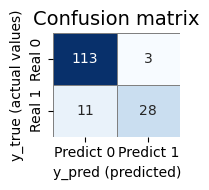


Accuracy:  0.91
Precision: 4.00
Recall:    12.00
F1 score:  6.00


,Predict 0,Predict 1
Real 0,113,3
Real 1,11,28


In [20]:
confusion_matrix_heatmap(y_true, y_pred)

In [21]:
def plot_roc_curve(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    auc_score = roc_auc_score(y_true, y_prob)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False positives rate (FPR)')
    plt.ylabel('True positives rate (TPR)')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

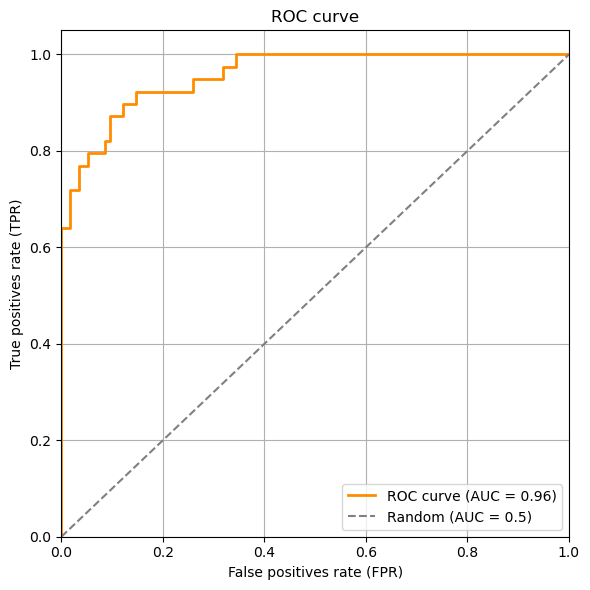

In [22]:
plot_roc_curve(y_true, y_pred)

In [23]:
def Gain_Lift_Chart(test_y, y_pred, n_bins=10):
    # sort the actual values in descending order of the prediction
    df = pd.DataFrame({'test_y': test_y, 'y_pred': y_pred})
    df = df.sort_values(by='y_pred', ascending=False).reset_index(drop=True)
    
    df['decile'] = pd.qcut(df.index, q=n_bins, labels=False)

    df['cumulative_positives'] = df['test_y'].cumsum()
    total_positives = df['test_y'].sum()
    df['gain'] = df['cumulative_positives'] / total_positives

    lift = []
    for i in range(n_bins):
        group = df[df['decile'] == i]
        if not group.empty:
            lift.append(group['test_y'].mean() / df['test_y'].mean())
        else:
            lift.append(0)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(np.linspace(0, 100, len(df)), df['gain'] * 100, label='Model')
    axs[0].plot([0, 100], [0, 100], '--', color='gray', label='Random')
    axs[0].set_title('Gains Chart')
    axs[0].set_xlabel('% Echantillon')
    axs[0].set_ylabel('% Positive')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].bar(range(1, n_bins + 1), lift)
    axs[1].set_title('Lift Chart')
    axs[1].set_xlabel('Decile (1 = top 10%)')
    axs[1].set_ylabel('Lift')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    
    # group the sorted predictions into 10 roughly equal groups and calculate the mean
    sorted_act_v = df['test_y']
    groups = [int(10 * i / len(sorted_act_v)) for i in range(len(sorted_act_v))]
    meanPercentile = sorted_act_v.groupby(groups).mean()
    meanResponse = meanPercentile / sorted_act_v.mean()
    meanResponse.index = (meanResponse.index + 1) * 10
    print('Lift based on meanResponse', meanResponse[10])
    random10 = sorted_act_v.cumsum().iloc[-1] / 10  # expected cumulative price without lift for 10% sales
    cumPred10 = sorted_act_v.cumsum().iloc[-1]/10  # cumulative price based on model for top 10%
    print('Expected cumulative price for 10% random sales', random10)
    print('Lift calculated based on gains chart', cumPred10 / random10)
    
    print(f"Lift du premier décile (top 10%) : {lift[0]:.2f}")


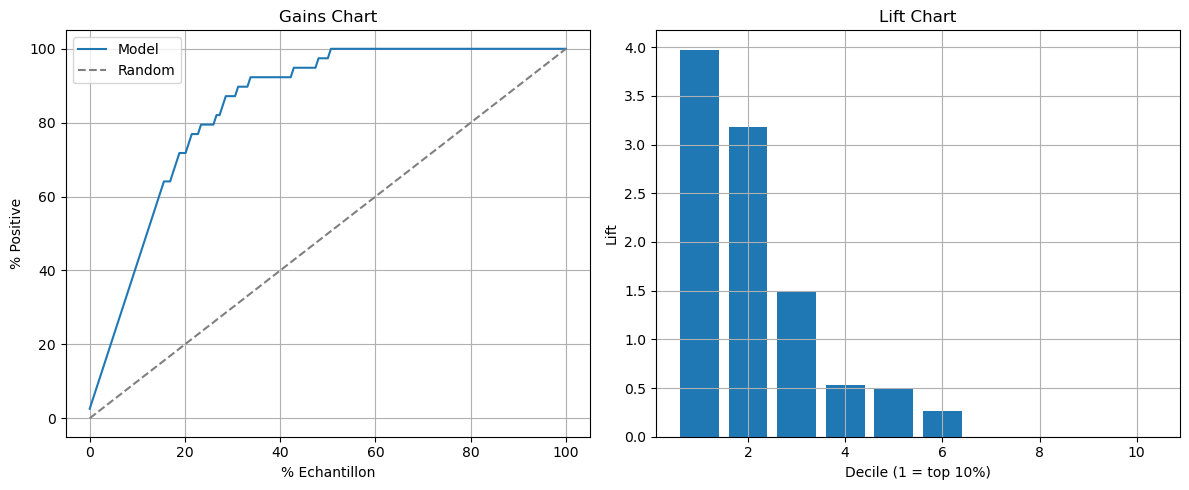

Lift based on meanResponse 3.974358974358975
Expected cumulative price for 10% random sales 3.9
Lift calculated based on gains chart 1.0
Lift du premier décile (top 10%) : 3.97


In [24]:
Gain_Lift_Chart(y_true, y_pred)

In [25]:
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
print(f"MSE on validation : {mse:.4f}")
print(f"RMSE on validation : {rmse:.4f}")
print(f"MAE on validation : {mae:.4f}")


MSE on validation : 0.0850
RMSE on validation : 0.2916
MAE on validation : 0.2202


Loop for testing other models (already implemented) :

In [ ]:
models = {
    "knn" : ;
    "log regression" : ;
    "decision tree" : ;
}